In [1]:
from pathlib import Path
import tarfile
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

Load data into the notebook

In [5]:
def load_housing_data():
    tarball_path = Path("/Users/luthfi/sandbox/Kaggle_competitions/Machine_learning/textbook/sandbox/datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        # makes a folder if the folder called 'datasets' doesn't exist
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)

        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("/Users/luthfi/sandbox/Kaggle_competitions/Machine_learning/textbook/sandbox/datasets/housing.csv"))

housing = load_housing_data()

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [57]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [58]:
housing.shape

(20640, 10)

Is there any missing values in the data ?

In [59]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Only total_bedrooms has missing values of 207

In [60]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


- the overall mean of all columns has an inconsistence of values ranging from 3.8 to 206855 -> this would cause certain attributes to be seen as more important than some because of their avg is higher for another. 
- This can also be seen for the std dev -> columns that have values of different ranges can cause the model to misinterpret by focusing on some columns more. Hence, standardization would be needed.

In [61]:
strat_train_set, strat_test_set = train_test_split(housing,test_size=0.2,random_state=42)

## Exploring + visualiza the data to gain insights

Explorating and visualization is only done on training sets.

In [62]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,291000.0,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,156100.0,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,353900.0,NEAR BAY
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,241200.0,<1H OCEAN
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,53800.0,INLAND


In [63]:
housing_vis = strat_train_set.copy()

### Visualize geographical data

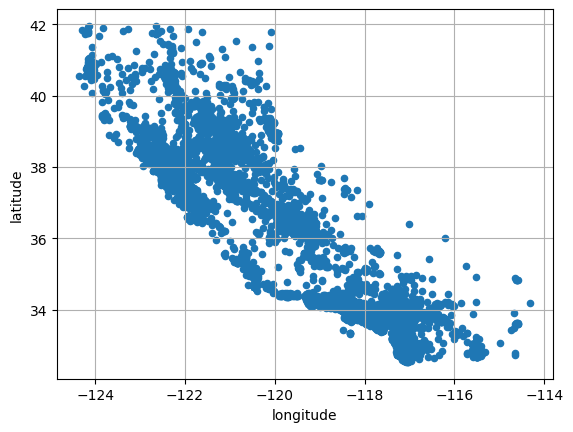

In [64]:
housing_vis.plot(kind='scatter',x='longitude',y='latitude',grid=True)
plt.show()

By setting alpha = 0.2 -> this allows each individual point more transparent, so when many points overlap, they visually stack up and appear darker.

<Axes: xlabel='longitude', ylabel='latitude'>

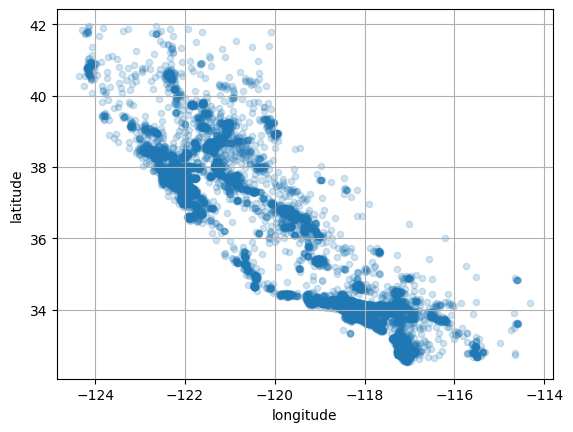

In [65]:
housing_vis.plot(kind='scatter',x='longitude',y='latitude',grid=True,alpha=0.2)

Housing prices - radius of each cicle represents the districts population and color represents the price

- the size of the circle represents the population size and the color of the circle represents the median_house_price based on the geographical points.

- sharex = False -> Relevant if you're plotting multiple subplots. In this context, it just means: don't share the x-axis scale with other plots.

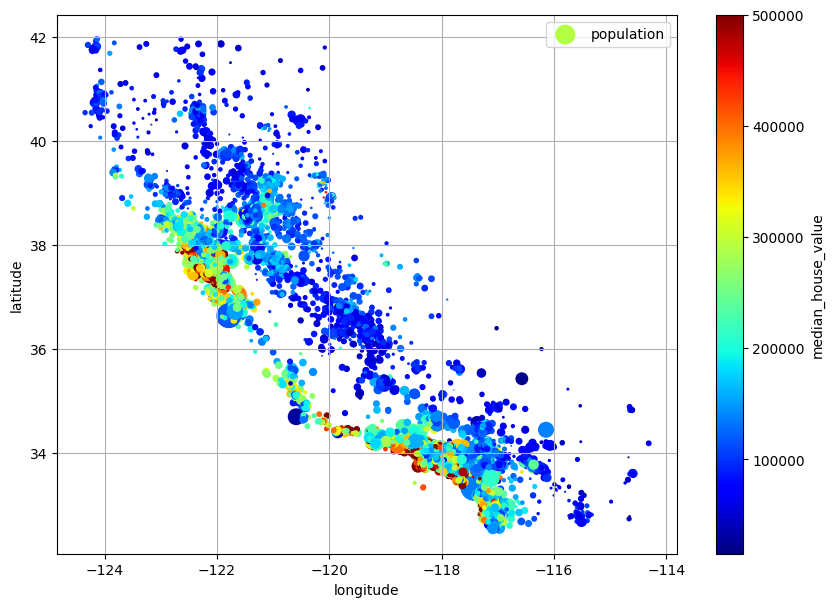

In [66]:
housing_vis.plot(kind='scatter',x='longitude',y='latitude',grid=True,
                 s = housing_vis['population'] / 100, label='population',
                 c = 'median_house_value', cmap='jet', colorbar=True,
                 legend=True,sharex=False,figsize=(10,7))
plt.show()

### Look for correlations

In [67]:
housing_num = housing_vis.select_dtypes(include=[np.number])
corr_matrix = housing_num.corr()

Gettings the correlation matrix of the median_house_value to see the correlation for the other columns against the median_house_value

In [68]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687013
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
population           -0.025820
longitude            -0.043603
latitude             -0.146324
Name: median_house_value, dtype: float64

The columns with a higher correlation to median_house_value = median_income, total_rooms, housing_median_age

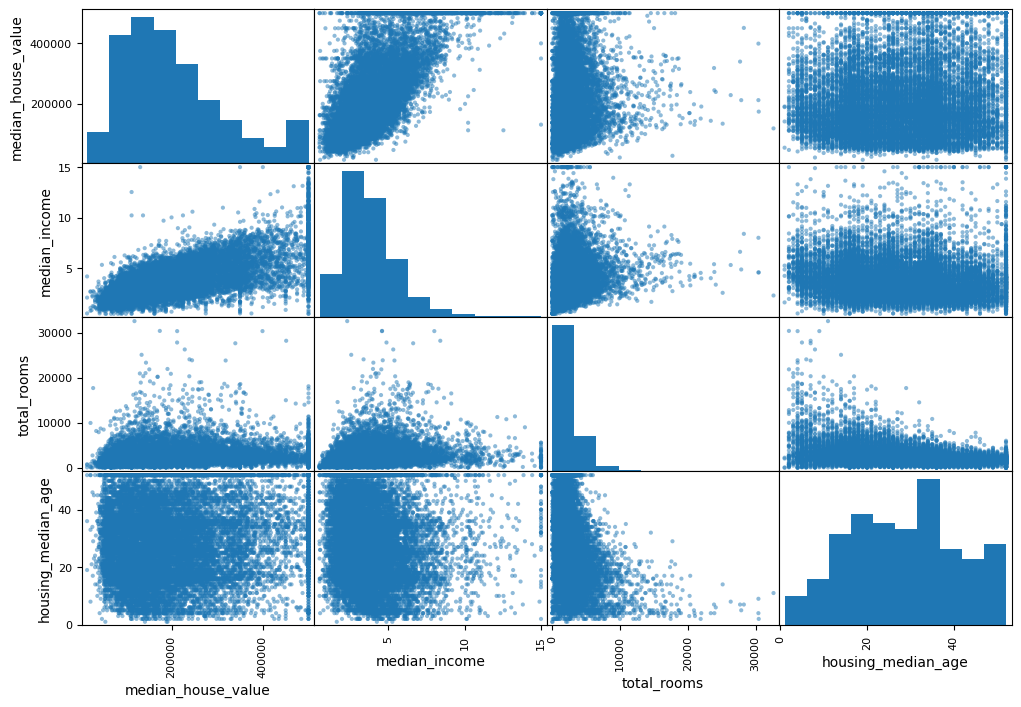

In [69]:
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing_vis[attributes],figsize=(12,8))
plt.show()

Based on the correlation matrix, median_income against median_house_value has a ascending data points.
Most promising attribute to predict the median_house_value is the median_income, now we'll zoom in on their scatterplot.

Alpha values and their effects:

- Alpha value |Transparency Level | Typical use case:

- 0.0 - 0.0 |Very transparent | To make points almost invisible, very subtle marks
- 0.2 - 0.4 |Light transparent | To reduce clutter, show overlaps softly (scatter)
- 0.5 - 0.7 | Moderate transparent |Balance visibility with some layering
- 0.8 - 1.0 | Low or no transprancy | Emphasize data points clearly, no overlap hiding

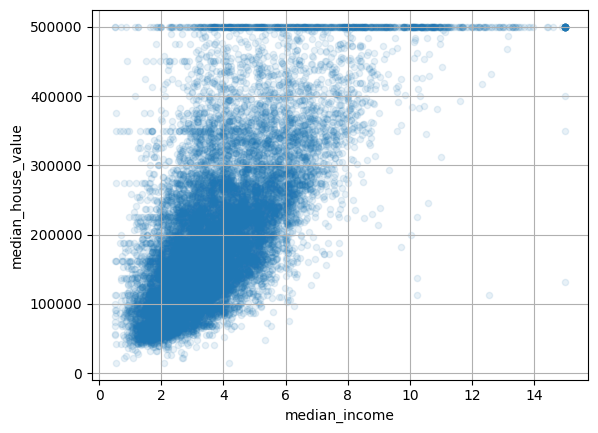

In [70]:
housing_vis.plot(kind='scatter',x='median_income',y='median_house_value',grid=True,alpha=0.1)
plt.show()

Based on this plot we can see the following:
- the correlation is indeed quite strong - you can clearly see the upward trend and the points are not too dispersed.
- The price cap you is noticeable this is clearly shown with the horizontal line at 50 000.

### Try combining attributes to have more value together than indiviually

In [71]:
housing_vis['rooms_per_house'] = housing_vis['total_rooms'] / housing_vis['households']
housing_vis['bedrooms_ratio'] = housing_vis['total_bedrooms'] / housing_vis['total_rooms']
housing_vis['people_per_house'] = housing_vis['population'] / housing_vis['households']

Now by finding the correlation of these new attributes will tell us how well they will contribute to the correlation of median_house_value

In [72]:
housing_num = housing_vis.select_dtypes(include=np.number)
corr_matrix = housing_num.corr()
corr_matrix['median_house_value'].sort_values(ascending= False)

median_house_value    1.000000
median_income         0.687013
rooms_per_house       0.146940
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
people_per_house     -0.021577
population           -0.025820
longitude            -0.043603
latitude             -0.146324
bedrooms_ratio       -0.254817
Name: median_house_value, dtype: float64

From the above new correlations against median_house_value:

- rooms_per_house : 0.1469
- bedrooms_ratio : -0.2548
- people_per_house : -0.2157

Based on these new correlations it has a much higher effect when combined together than having these attrributes seperate.

## Prep Data for ML algo's

### Seperate the data into X and Y

In [73]:
housing_X = housing_vis.drop('median_house_value',axis=1)
housing_X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_house', 'bedrooms_ratio',
       'people_per_house'],
      dtype='object')

In [74]:
housing_y = housing['median_house_value'].copy()
housing_y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

## Handling the missing values for the X values only

In [75]:
housing_X.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        163
population              0
households              0
median_income           0
ocean_proximity         0
rooms_per_house         0
bedrooms_ratio        163
people_per_house        0
dtype: int64

### Handling numeric

In [76]:
housing_X_num = housing_X.select_dtypes(include=np.number)
housing_X_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio,people_per_house
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,5.597948,0.185136,2.475746
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,5.395210,0.180910,4.179641
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,4.655660,0.224924,2.004043
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,6.186154,0.157672,3.350769
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,10.000000,0.191667,2.625000
...,...,...,...,...,...,...,...,...,...,...,...
11284,-122.37,37.94,49.0,969.0,229.0,599.0,195.0,1.3167,4.969231,0.236326,3.071795
11964,-118.38,33.89,35.0,1778.0,330.0,732.0,312.0,6.5745,5.698718,0.185602,2.346154
5390,-119.33,36.28,16.0,2624.0,527.0,1077.0,520.0,2.1250,5.046154,0.200838,2.071154
860,-117.19,34.08,22.0,2467.0,555.0,1567.0,494.0,2.6536,4.993927,0.224970,3.172065


In [77]:
housing_X_num.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio,people_per_house
count,16512.000000,16512.000000,16512.000000,16512.000000,16349.000000,16512.000000,16512.000000,16512.000000,16512.000000,16349.000000,16512.000000
mean,-119.565121,35.631252,28.592720,2635.515928,538.923420,1428.123123,500.259993,3.863585,5.433218,0.213014,3.096933
std,1.999323,2.133670,12.618367,2142.925654,418.202807,1134.043862,379.273307,1.907402,2.559493,0.057433,11.580499
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.888889,0.100000,0.692308
25%,-121.780000,33.940000,18.000000,1454.750000,296.000000,788.000000,280.000000,2.561150,4.436599,0.175426,2.427791
50%,-118.490000,34.250000,29.000000,2129.000000,437.000000,1169.000000,411.000000,3.524600,5.232422,0.203059,2.819566
75%,-118.010000,37.720000,37.000000,3152.250000,648.000000,1726.000000,606.000000,4.727000,6.049091,0.240125,3.286385
max,-114.310000,41.950000,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100,141.909091,1.000000,1243.333333


In [78]:
housing_X_num.median().values.round() # The expected median values for each column

array([-118.,   34.,   29., 2129.,  437., 1169.,  411.,    4.,    5.,
          0.,    3.])

Simple imputer would be used to handling the missing values for the data

### Handling text + categorical attributes

In [79]:
housing_X_cat = housing_X['ocean_proximity']
housing_X_cat.unique()

array(['NEAR OCEAN', 'NEAR BAY', '<1H OCEAN', 'INLAND', 'ISLAND'],
      dtype=object)

OneHot Encoder would be best suited for the categorical column

## Type of Feature Scaling

In [80]:
housing_X_num.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio,people_per_house
count,16512.000000,16512.000000,16512.000000,16512.000000,16349.000000,16512.000000,16512.000000,16512.000000,16512.000000,16349.000000,16512.000000
mean,-119.565121,35.631252,28.592720,2635.515928,538.923420,1428.123123,500.259993,3.863585,5.433218,0.213014,3.096933
std,1.999323,2.133670,12.618367,2142.925654,418.202807,1134.043862,379.273307,1.907402,2.559493,0.057433,11.580499
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.888889,0.100000,0.692308
25%,-121.780000,33.940000,18.000000,1454.750000,296.000000,788.000000,280.000000,2.561150,4.436599,0.175426,2.427791
50%,-118.490000,34.250000,29.000000,2129.000000,437.000000,1169.000000,411.000000,3.524600,5.232422,0.203059,2.819566
75%,-118.010000,37.720000,37.000000,3152.250000,648.000000,1726.000000,606.000000,4.727000,6.049091,0.240125,3.286385
max,-114.310000,41.950000,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100,141.909091,1.000000,1243.333333


From the above describe we can see that there is specific range and all the features are not on the same scale, hence standardization would be a better option.

## Transformation

Using both the log transformation + Radial Basis Function (RBF):

- Log transformation : helps with large skewed data + flatten the data and reduce the effect of big numbers

- RBF : helps to find hidden patterns or groupings in the data

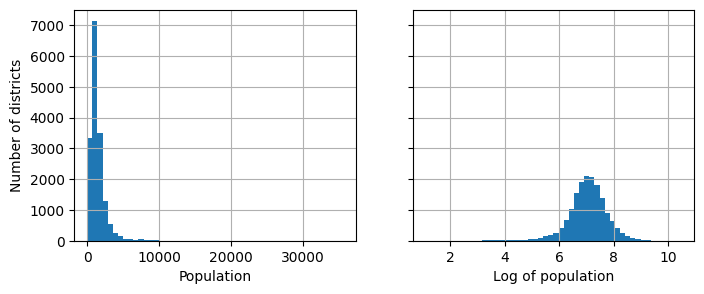

In [81]:
fig, axs = plt.subplots(1,2,figsize=(8,3), sharey=True)
housing_X['population'].hist(ax=axs[0],bins=50)
housing_X['population'].apply(np.log).hist(ax=axs[1],bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

## Scale the target

TransformedTargetRegressor - > this basically compresses the target value into a small amount during the training and the revserse the scaling during prediction

In [82]:
target_value = housing_y

## Create a custom transformer for the RBF : To help find hidden patterns or groupings in the data 

Custom transformer  =  uses KMeans cluster to fit() method to identify the main clusters in the training data + uses rbf_kernel() in the transform() method to measure how similar each simple is to each cluster center.

In [83]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_clusters=10,gamma=1.0,random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state


    def fit(self,X,y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters,random_state=self.random_state)
        self.kmeans_.fit(X,sample_weight=sample_weight)
        return self
    
    def transform(self,X):
        return rbf_kernel(X,self.kmeans_.cluster_centers_,gamma=self.gamma)
    
    def get_feature_names_out(self,names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [84]:
cluster_siml = ClusterSimilarity(n_clusters=10,gamma=1.,random_state=42)
similarities = cluster_siml.fit_transform(housing[["latitude", "longitude"]],sample_weight=housing_y)

In [85]:
print(target_value)

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64


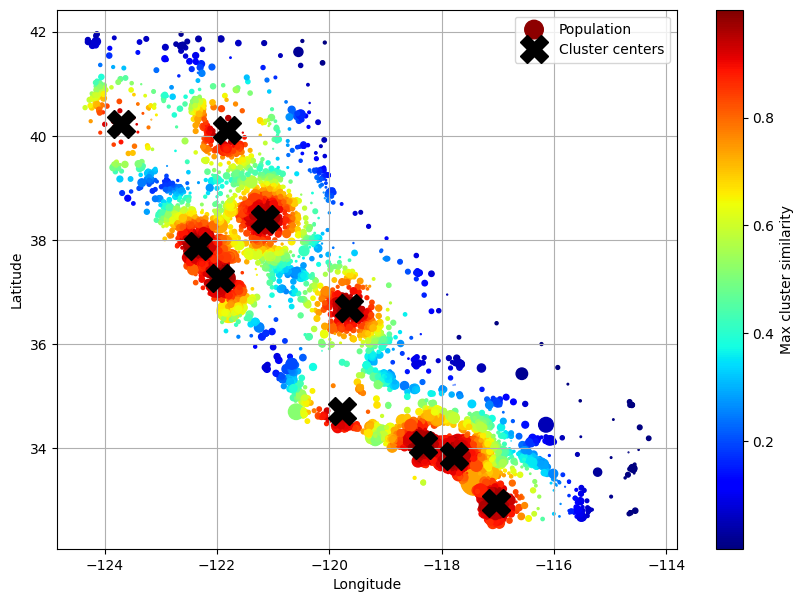

In [86]:
housing_remained = housing.rename(columns={
"latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"
})

housing_remained["Max cluster similarity"] = similarities.max(axis=1)

housing_remained.plot(kind="scatter", x= "Longitude", y="Latitude",grid = True,
                      s = housing_remained["Population"] / 100, label = "Population",
                      c= "Max cluster similarity",
                      cmap ="jet", colorbar = True, legend=True, sharex=False, figsize = (10,7))

plt.plot(cluster_siml.kmeans_.cluster_centers_[:,1],
        cluster_siml.kmeans_.cluster_centers_[:,0],
        linestyle="", color='black', marker="X", markersize=20,
        label = "Cluster centers")

plt.legend(loc="upper right")
plt.show()

## Creating the preprocessing pipeline

This takes in numerical data, fills in any missing values with the median + scales the values so they're on the same scale

In [87]:
num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

In [88]:
# See the pipelie being created
set_config(display='diagram')
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

Seperate numerical and categorical columns

In [89]:
num_attributes = ['longitiude','latitude','housing_median_age','total_rooms','total_bedrooms','popluation',
                  'households', 'median_income']

cat_attributes = ['ocean_proximity']

Create a categorical pipeline, that fills in the missing values and apply an encoder

In [90]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown="ignore")
)

Bring both the numerical and categorical pipeline together using ColumnTransformer()

This would be for a simple pipeline, with no custom transformers and no additional columns created

In [91]:
preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', cat_pipeline,cat_attributes)
])

Adding additional things to the pipeline
- column_ratio (combining two columns together to get a more corrlated columns instead)
- creating a pipeline for this new column_ratio columns
- use transformer log to scale the data by using its log value - used for large column values 
- calling the custom transformer for finding the hidden clusters and its similarity

In [92]:
housing_X = strat_train_set.copy()
housing_X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [93]:
housing_X=housing_X.drop(columns=['median_house_value'])

In [94]:
def column_ratio(X):
    return X[:,[0]] / X[:,[1]]

In [95]:
def ratio_name (function_transformer,feature_names_in):
    return ['ratio']

In [96]:
# Create a method so it can be reused for multiple columns
def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

Create the log transformer + its pipeline

In [97]:
log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

In [98]:
cluster_siml = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

In [99]:
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                     StandardScaler())

In [100]:
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_siml, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)

In [101]:
housing_X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [102]:
housing_prepared = preprocessing.fit_transform(housing_X)
housing_prepared.shape

(16512, 24)

In [103]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Train a model

## Basic Linear Regression

In [104]:
housing_X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,NEAR BAY
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,<1H OCEAN
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,INLAND


In [105]:
housing_y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

In [106]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing,LinearRegression())

lin_reg.fit(housing_X, housing_y)

ValueError: Found input variables with inconsistent numbers of samples: [16512, 20640]